# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt

# Pre-Processing

In [3]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

# Option type
option_type = "put"

# Convert Unix timestamps to datetime
df['QUOTE_DATETIME'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

# Load underlying price data for volatility computation
underlying_prices = df[['QUOTE_DATETIME', '[UNDERLYING_LAST]']].drop_duplicates().set_index('QUOTE_DATETIME').sort_index()

# Function to compute historical volatility
def historical_volatility(series, window=20):
    return np.sqrt(252) * series.pct_change().rolling(window=window).std()

# Compute 20-day historical volatility
underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
underlying_prices.dropna(inplace=True)

# Merge historical volatility back into main dataframe
df = df.merge(underlying_prices[['hist_vol_20d']], left_on='QUOTE_DATETIME', right_index=True, how='inner')

# For call options, use the call columns; we want to predict best_bid ([C_BID]) and best_offer ([C_ASK]).
if option_type == 'call':
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                    '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
else:
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                    '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

   
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
# Drop rows with missing data in the essential columns

if option_type == 'call':
    essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d', '[C_BID]', '[C_ASK]']
else:
    essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d', '[P_BID]', '[P_ASK]']

df.dropna(subset=essential_cols, inplace=True)

# Prepare a DataFrame for call options
if option_type == "call":
    option_cols = [
        '[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
        '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]',
        '[C_BID]', '[C_ASK]'
    ]
    col_rename = [
        'underlying_price', 'strike_price', 'days_to_expiry',
        'hist_volatility', 'delta', 'gamma', 'vega', 'theta',
        'rho', 'best_bid', 'best_offer'
    ]
    model_file = 'call-mlp2.h5'
else:
    # Finish code here for puts
    option_cols = [
        '[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
        '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]', '[P_RHO]',
        '[P_BID]', '[P_ASK]'
    ]
    col_rename = [
        'underlying_price', 'strike_price', 'days_to_expiry',
        'hist_volatility', 'delta', 'gamma', 'vega', 'theta',
        'rho', 'best_bid', 'best_offer'
    ]
    model_file = 'put-mlp2.h5'

option_df = df[option_cols].copy()
option_df.columns = col_rename

# Normalize strike price and compute time to expiry in years
option_df['strike_price'] = option_df['strike_price'] / 1000
option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
option_df.drop('days_to_expiry', axis=1, inplace=True)

# Save the processed option data to CSV, uncomment if needed
# option_df.to_csv(output_file, index=False)

# Hyperparameters

In [4]:
# Hyperparameters
n_units_per_layer = [256, 32, 2]
layers = 3
n_batch = 1024
n_epochs = 50

# Building model

In [5]:
feature_cols = ['underlying_price', 'strike_price', 'hist_volatility', 'delta', 'gamma', 
                'vega', 'theta', 'rho', 'time_to_expiry']
target_cols = ['best_bid', 'best_offer']

X = option_df[feature_cols]
y = option_df[target_cols]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create model 
model = Sequential()

# Scale data remains unchanged
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add first layer without ativation
model.add(Dense(n_units_per_layer[0], input_shape=(X_train_scaled.shape[1],)))
model.add(Activation('relu'))

# Define Keras MLP model using LeakyReLU in subsequent layers
for i in range(1, layers - 1):
    model.add(Dense(n_units_per_layer[i]))
    model.add(Activation('relu'))

# Add last layer
model.add(Dense(n_units_per_layer[-1]))
model.add(Activation('relu'))

# Learning rate scheduling remains unchanged
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1  # reduce LR by 10x every 10 epochs
    return lr

lr_callback = LearningRateScheduler(scheduler)

early_stop = EarlyStopping(
    monitor='val_loss',       # what to monitor
    patience=5,               # how many epochs to wait before stopping
    restore_best_weights=True,  # restores weights from best epoch
    verbose=1
)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,850 (42.38 KB)

 Trainable params: 10,850 (42.38 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [35]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=n_batch, validation_split=0.2, verbose=1, callbacks=[lr_callback, early_stop])

loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {mae}")

# Save the model
model.save(model_file)

Epoch 1/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 861.3691 - mae: 12.7501 - val_loss: 4.4027 - val_mae: 1.2739 - learning_rate: 0.0010
Epoch 2/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.8596 - mae: 1.1381 - val_loss: 2.3422 - val_mae: 0.9096 - learning_rate: 0.0010
Epoch 3/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7583 - mae: 0.8799 - val_loss: 1.7338 - val_mae: 0.7863 - learning_rate: 0.0010
Epoch 4/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4307 - mae: 0.7711 - val_loss: 1.3665 - val_mae: 0.6929 - learning_rate: 0.0010
Epoch 5/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3208 - mae: 0.6847 - val_loss: 1.1072 - val_mae: 0.6454 - learning_rate: 0.0010
Epoch 6/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4110 - mae: 0.6214 - val_loss: 0.9429 - val_mae: 0.5669 - learning_rate: 0.0010
Epoch 7/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8787 - mae: 0.5514 - val_loss: 0.8052 - val_mae: 0.5184 - learning_rate: 0.0010
Ep

Test MAE: 0.39540061354637146


# Plot the loss

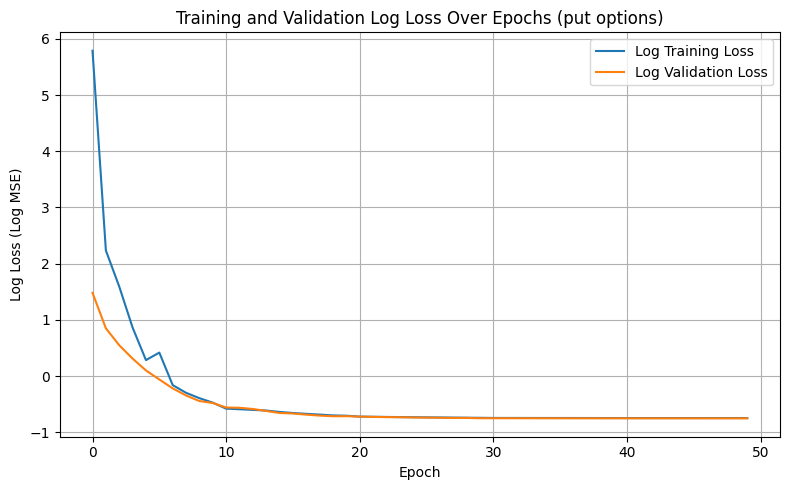

In [36]:
eps = 1e-10  # to avoid log(0)
plt.figure(figsize=(8, 5))

plt.plot(np.log(np.array(history.history['loss']) + eps), label='Log Training Loss')
plt.plot(np.log(np.array(history.history['val_loss']) + eps), label='Log Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Log Loss (Log MSE)')
plt.title(f'Training and Validation Log Loss Over Epochs ({option_type} options)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the trained model
model.save(model_file)


# Plot the prediciton equilbrium versus actual

4843/4843 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step


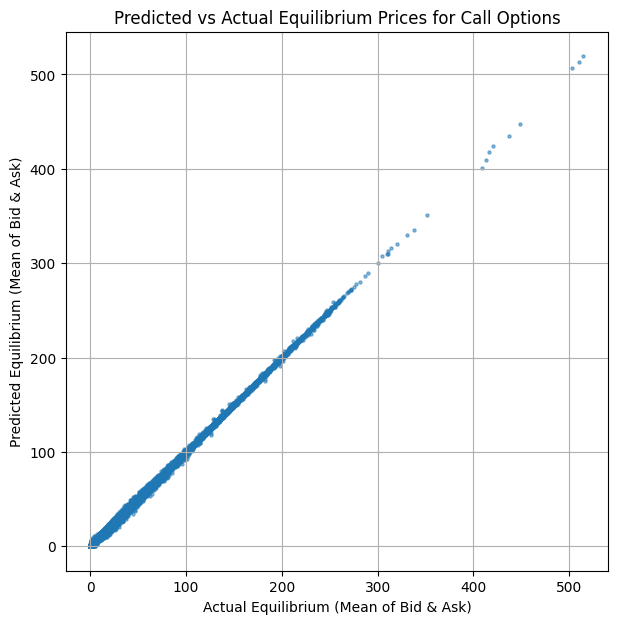

In [6]:
loaded_model = load_model(model_file)
predictions = loaded_model.predict(X_test_scaled)

# Cell 8: Optional - Plot Predicted vs Actual Equilibrium Values
plt.figure(figsize=(7, 7))
plt.scatter(np.mean(y_test.values, axis=1), np.mean(predictions, axis=1), s=5, alpha=0.5)
plt.xlabel('Actual Equilibrium (Mean of Bid & Ask)')
plt.ylabel('Predicted Equilibrium (Mean of Bid & Ask)')
plt.title('Predicted vs Actual Equilibrium Prices for Call Options')
plt.grid(True)
plt.show()

# Plot predicted bid versus actual

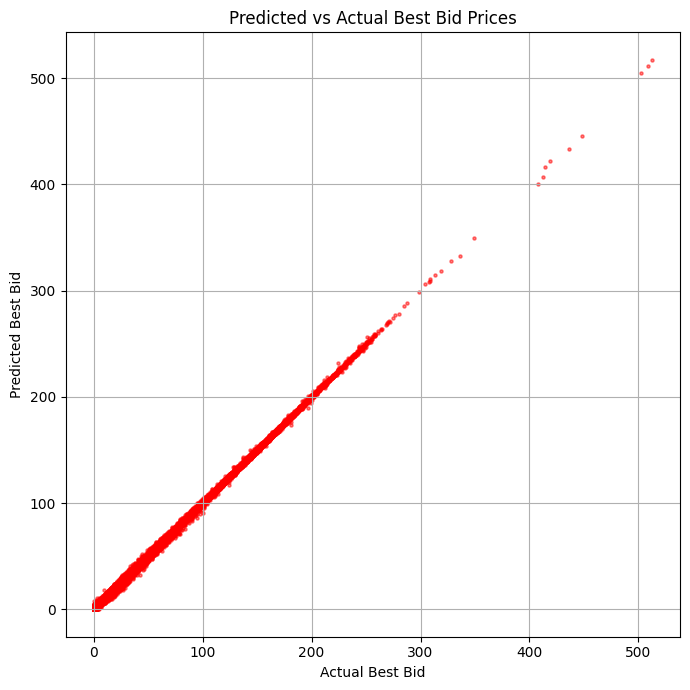

In [7]:
# Best Bid Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_test['best_bid'], predictions[:, 0], s=5, alpha=0.5, color="red")
plt.xlabel('Actual Best Bid')
plt.ylabel('Predicted Best Bid')
plt.title('Predicted vs Actual Best Bid Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Best Offer Plot

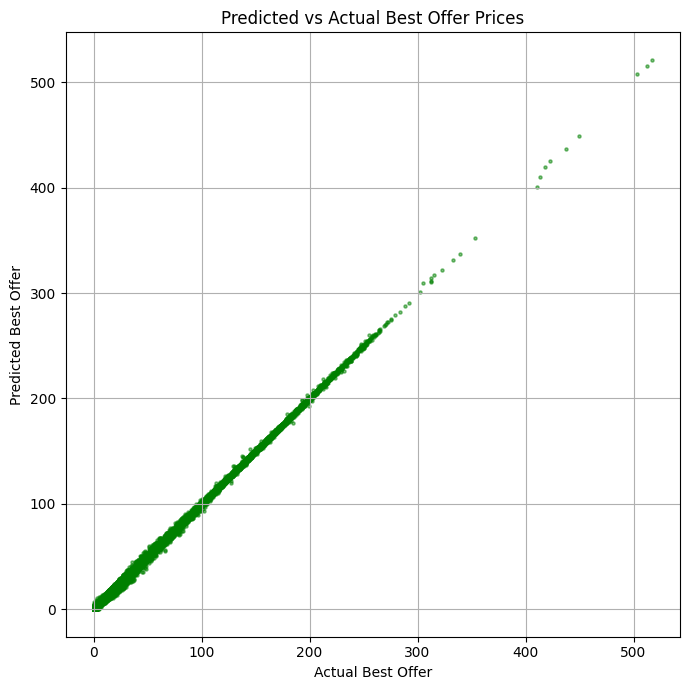

In [8]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test['best_offer'], predictions[:, 1], s=5, alpha=0.5, color="green")
plt.xlabel('Actual Best Offer')
plt.ylabel('Predicted Best Offer')
plt.title('Predicted vs Actual Best Offer Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Test random entries

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4843/4843 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step
         Actual Best Bid  Predicted Best Bid  Actual Best Offer  \
1325146             0.02            0.000000               0.05   
1024533             2.00            2.195039               2.05   
1192918            10.55           10.318092              10.95   
1536640             4.30            3.871899               4.45   
1407828             0.22            0.000000               0.26   
544120             25.71           25.472897              26.26   
353423             68.81           67.805962              69.05   
1099889            74.70           76.096497              77.30   
1409868             0.32            0.129189               0.38   
1040140             0.00            0.000000               0.04   

         Predicted Best Offer  
1325146              0.000000  
1024533              2.274523  
1192918             10.404329  
1536640              4.096276  
1407828            

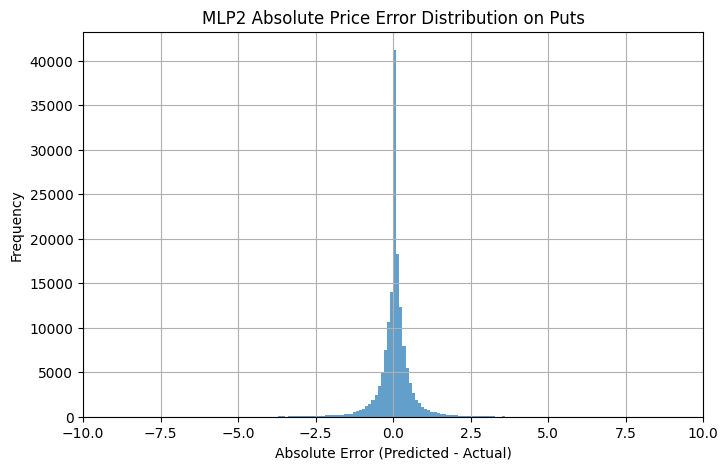

In [9]:
loaded_model = load_model(model_file)

# Select a random sample of 10 entries
sample_entries = X.sample(10)
sample_indices = sample_entries.index

# Scale the sample entries and generate predictions
sample_scaled = scaler.transform(sample_entries)
sample_preds = loaded_model.predict(sample_scaled)

predictions = loaded_model.predict(X_test_scaled)
# Build a DataFrame to compare actual vs. predicted values
results_df = pd.DataFrame({
    'Actual Best Bid': y.loc[sample_indices, 'best_bid'].values,
    'Predicted Best Bid': sample_preds[:, 0],
    'Actual Best Offer': y.loc[sample_indices, 'best_offer'].values,
    'Predicted Best Offer': sample_preds[:, 1]
}, index=sample_indices)

print(results_df)

# ---- Absolute Error Analysis ----
abs_errors = np.mean(y_test.values, axis=1) - np.mean(predictions, axis=1)

# Plot histogram of absolute errors
plt.figure(figsize=(8, 5))
plt.hist(abs_errors, bins = np.arange(-10, 10.1, 0.1), alpha=0.7)
plt.xlabel("Absolute Error (Predicted - Actual)")
plt.ylabel("Frequency")
plt.xlim([-10, 10])
plt.title("MLP2 Absolute Price Error Distribution on Puts")
plt.grid(True)
plt.show()

# Calculate error metrics

In [8]:
# Calculate equilibrium price (mean of bid and ask) for actual and predicted values
actual_equilibrium = np.mean(y_test.values, axis=1)
predicted_equilibrium = np.mean(predictions, axis=1)

# Compute errors (actual minus predicted equilibrium prices)
errors = actual_equilibrium - predicted_equilibrium

# Calculate metrics based on equilibrium prices
mean_error = np.mean(errors)
std_error = np.std(errors)
mae_eq = mean_absolute_error(actual_equilibrium, predicted_equilibrium)
rmse_eq = np.sqrt(mean_squared_error(actual_equilibrium, predicted_equilibrium))
max_error_value = np.max(errors)  # Worst overprediction (largest positive error)
min_error_value = np.min(errors)  # Worst underprediction (largest negative error)
r2 = r2_score(actual_equilibrium, predicted_equilibrium)


y_true = actual_equilibrium
y_pred = predicted_equilibrium
# Create a mask to filter out zero or near-zero actual prices
valid_mask = np.abs(y_true) > 0

# Apply the mask
y_true_valid = y_true[valid_mask]
y_pred_valid = y_pred[valid_mask]

# Now calculate percent errors without worrying about divide-by-zero
abs_percent_errors = 100 * np.abs((y_pred_valid - y_true_valid) / y_true_valid)

# PE metrics
def compute_pe(abs_percent_errors, threshold):
    return np.mean(abs_percent_errors <= threshold) * 100

# Compute standard deviation of absolute percent errors
std_e = np.std(errors)
print(f"PE5:  {compute_pe(abs_percent_errors, 5):.2f}%")
print(f"PE10: {compute_pe(abs_percent_errors, 10):.2f}%")
print(f"PE20: {compute_pe(abs_percent_errors, 20):.2f}%")

# Print the results
print(f"Mean Error: {mean_error:.4f}")
print(f"Standard Deviation of Error: {std_error:.4f}")
print(f"Mean Absolute Error (MAE): {mae_eq:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_eq:.4f}")
print(f"Max Error (worst overprediction): {max_error_value:.4f}")
print(f"Min Error (worst underprediction): {min_error_value:.4f}")
print(f"R² Score: {r2:.4f}")

predictions = loaded_model.predict(X_train_scaled)


predicted_equilibrium = np.mean(predictions, axis=1)
actual_equilibrium = np.mean(y_train.values, axis=1)

# Compute MAE after inverse scaling
train_mae_corrected = mean_absolute_error(actual_equilibrium, predicted_equilibrium)
print(f"Corrected Train MAE: {train_mae_corrected}")


PE5:  50.08%
PE10: 58.64%
PE20: 65.87%
Mean Error: 0.0527
Standard Deviation of Error: 0.6076
Mean Absolute Error (MAE): 0.3309
Root Mean Squared Error (RMSE): 0.6099
Max Error (worst overprediction): 10.5136
Min Error (worst underprediction): -7.6758
R² Score: 0.9998
43581/43581 ━━━━━━━━━━━━━━━━━━━━ 12s 281us/step
Corrected Train MAE: 0.33115616854993224
